## Required PIP Installations in Terminal Before Running Code

In [153]:
# git clone https://github.com/facebookresearch/Pearl.git
# cd Pearl
# pip install -e .
# cd ..
#
# pip install gym_trading_env  

##### instructions for installing FinTA (Financial Technical Analysis) python Added 10 Oct 2024 #####
#Note:  pip install finta


In [1]:
import gym_trading_env
from gym_trading_env.downloader import download, EXCHANGE_LIMIT_RATES
from gym_trading_env.renderer import Renderer
import gymnasium as gym
import datetime

import pandas as pd
from pandas.core import series
import numpy as np

# finta Lib - A Library of Technical Analysis Functions  
from finta import TA

import os # used to get current directory
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from hyperopt import hp,tpe,fmin, STATUS_OK, Trials # for hyperparameterization
from hyperopt.pyll.stochastic import sample
from hyperopt import space_eval

# Import all the Pearl related methods
from pearl.pearl_agent import PearlAgent
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)
from pearl.policy_learners.sequential_decision_making.deep_q_learning import (
    DeepQLearning,
)
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.policy_learners.sequential_decision_making.implicit_q_learning import ImplicitQLearning
from pearl.utils.functional_utils.train_and_eval.offline_learning_and_evaluation import (
    get_offline_data_in_buffer,
    offline_evaluation,
    offline_learning,
)
from pearl.neural_networks.sequential_decision_making.actor_networks import VanillaContinuousActorNetwork
from pearl.pearl_agent import PearlAgent
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)
from pearl.policy_learners.sequential_decision_making.deep_q_learning import (
    DeepQLearning,
)
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
import torch # used for calculating the mean when evaluating Pearl training performance

##FOR USE WITH VANILLAQVALUENETWORK
#from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork

experiment_seed = 42

c:\Users\548253\AppData\Local\anaconda3\envs\gym-trader5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# run this multiple times on purpose b/c it 
import warnings
warnings.simplefilter('ignore')
warnings.simplefilter('ignore')
warnings.simplefilter('ignore')

In [4]:
# Download data from site
EXCHANGE_LIMIT_RATES["binanceus"] = {
    "limit" : 200, # One request will query 200 data points (aka candlesticks).
    "pause_every" : 120, # it will pause every 120 requests.
    "pause" : 2, # the pause will last 2 seconds.
}
download(
    exchange_names = ["binanceus"],
    symbols= ["ICP/USDT"],
    timeframe= "1h",
    dir = "data",
    since= datetime.datetime(year= 2024, month= 9, day=1),
)

ICP/USDT downloaded from binanceus and stored at data/binanceus-ICPUSDT-1h.pkl


In [5]:
# #function to remove $ sign from dataframe ohclv features.  Don't know if we need it yet, in order to finta TA functions.
# def split(dollar: str) -> float:
#     return float(dollar.split("$")[1])

In [6]:
# def get_newcsvfilename(filename: str):
#     filename_w_ext = os.path.basename(filename)
#     base, ext = os.path.splitext(filename)
#     print(filename)
#     print(base)
#     print(ext)
#     newfilename = base + ".csv"
#     print(newfilename)
#     return newfilename

In [7]:
def get_data(filename: str):
    if filename[:6] != "./data/":
        filename = "./data/" + filename

    # df is a DataFrame with original columns : "open", "high", "low", "close", "Volume USD"
    df = pd.read_pickle(filename)

    df.sort_index(inplace= True)

    df["feature_sma10"] = TA.SMA(df, 10)
    df["feature_sma5"] = TA.SMA(df, 5)
    df["feature_rsi"] = TA.RSI(df)
    bbands = TA.BBANDS(df)   #Returns Series with Bollinger Bands Columns[BB_UPPER, BB_LOSER]
    df[["feature_" + col for col in bbands.columns]] = bbands
    macd = TA.VW_MACD(df)
    df[["macd_" + col for col in macd.columns]] = macd
    df["feature_storchrsi"] = TA.STOCHRSI(df)
    df["feature_adl"] = TA.ADL(df)
    df["feature_adx"] = TA.ADX(df)
    ppo = TA.PPO(df)
    df[["ppo_" + col for col in ppo.columns]] = ppo
    df["feature_chaikin"] = TA.CHAIKIN(df)
    df["feature_cci"] = TA.CCI(df)
    df["feature_copp"] = TA.COPP(df)
    
    # Create the feature : ( close[t] - close[t-1] )/ close[t-1]
    df["feature_close"] = df["close"].pct_change()

    # Create the feature : open[t] / close[t]
    df["feature_open"] = df["open"]/df["close"]

    # Create the feature : high[t] / close[t]
    df["feature_high"] = df["high"]/df["close"]

    # Create the feature : low[t] / close[t]
    df["feature_low"] = df["low"]/df["close"]

    # Create the feature : volume[t] / max(*volume[t-7*24:t+1])
    # Create the feature : volume[t] / max(*volume[2])
    df["feature_volume"] = df["volume"] / df["volume"].rolling(2).max()

    # Simple moving averages of 10 and 5 units of time
    df["feature_sma10"] = df["close"].rolling(10).mean()
    df["feature_sma5"] = df["close"].rolling(5).mean()

   

    
    df.dropna(inplace= True) # Clean again !
    # Each step, the environment will return 5 inputs  : "feature_close", "feature_open", "feature_high", "feature_low", "feature_volume"

    return df 



In [8]:
df = get_data("binanceus-ICPUSDT-1h.pkl")
df

,open,high,low,close,volume,date_close,feature_sma10,feature_sma5,feature_rsi,feature_BB_UPPER,...,ppo_SIGNAL,ppo_HISTO,feature_chaikin,feature_cci,feature_copp,feature_close,feature_open,feature_high,feature_low,feature_volume
date_open,,,,,,,,,,,,,,,,,,,,,
2024-09-01 14:00:00,7.260,7.321,7.212,7.321,166.04,2024-09-01 15:00:00,7.3453,7.3090,30.726289,7.612286,...,-0.375200,-0.115449,52.547663,-115.156553,-4.987003,0.002877,0.991668,1.000000,0.985111,1.000000
2024-09-01 15:00:00,7.349,7.426,7.349,7.426,52.98,2024-09-01 16:00:00,7.3519,7.3294,52.103034,7.604627,...,-0.376984,-0.007096,52.480776,-15.342307,-4.130492,0.014342,0.989631,1.000000,0.989631,0.319080
2024-09-01 17:00:00,7.293,7.293,7.257,7.257,12.49,2024-09-01 18:00:00,7.3337,7.3268,33.557465,7.577139,...,-0.394332,-0.060841,38.153374,-113.757330,-3.690235,-0.009959,1.004961,1.004961,1.000000,1.000000
2024-09-01 18:00:00,7.351,7.426,7.351,7.426,29.61,2024-09-01 19:00:00,7.3355,7.3520,52.525149,7.551887,...,-0.383385,0.043659,36.225716,14.492754,-2.947316,0.023288,0.989900,1.000000,0.989900,1.000000
2024-09-01 21:00:00,7.380,7.380,7.330,7.330,3.98,2024-09-01 22:00:00,7.3542,7.3730,43.678575,7.485129,...,-0.295398,0.092448,27.848160,-27.925747,-1.345529,-0.012928,1.006821,1.006821,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-16 07:00:00,7.936,7.983,7.899,7.958,21.44,2024-10-16 08:00:00,8.0267,7.9810,43.633208,8.212951,...,-0.546729,-0.087149,161.849161,-107.646108,-2.212558,0.001006,0.997235,1.003141,0.992586,1.000000
2024-10-16 08:00:00,7.958,7.979,7.958,7.978,152.19,2024-10-16 09:00:00,8.0216,7.9718,44.843774,8.207116,...,-0.563294,-0.066262,175.947298,-72.103612,-2.121630,0.002513,0.997493,1.000125,0.997493,1.000000
2024-10-16 09:00:00,7.949,8.002,7.948,8.002,19.02,2024-10-16 10:00:00,8.0101,7.9806,46.333260,8.129828,...,-0.569670,-0.025503,170.360005,-51.989026,-1.898697,0.003008,0.993377,1.000000,0.993252,0.124975


## Split the data into train and test data; need consecutive dates in each

In [9]:
split_date=pd.to_datetime('09/25/2024')
train_df=df[:split_date]
test_df=df[split_date:]


## Define Reward Functions

In [10]:
# function is a logarithm of the quotient of the last last 2 timesteps (one hour apart)
def log_reward_function(history):
        return np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2])

# function is the difference between the last 2 time steps
def diff_reward_function(history):
        return history["portfolio_valuation", -1] - history["portfolio_valuation", -2]

# An total growth of the portfolio since first timestep
def cumulative_reward_function(history):
        return np.diff(history["portfolio_valuation", -1] , history["portfolio_valuation", 0])/len(history["portfolio_valuation"])

# Shape Ratio reward function
def shape_reward_function(history):
        return history["portfolio_valuation", -1] /np.std(history["portfolio_valuation"])

# Final evaluation (total portfolio increase/decrease)
def final_evalulation(history):
        return (history["portfolio_valuation", -1] / history["portfolio_valuation", 0]) - 1

def n_trades(history):
        return sum(np.abs(np.diff(history['position'])))

In [11]:
def make_env(env_name, df, positions, reward_function, trading_fees, daily_borrow_interest=0.000072):
# Trading Fees and Daily Borrow Interest are ratios (so percent / 100)
#
# Positions are the actions the agent can take (buy/sell/short/nothing) as ranges -inf to inf including decimal values.
# These are the possible actions our agent will take. Sample values:
#      1 = Long entire portfolio value = spend entire portfolio value on buying X, betting the price of X will rise and can sell for a profit
#     -1 = Short entire portfolio value = Borrow & immediately sell X worth the entire portfolio value, betting the price of X will drop and can buy back
#     0.5= Long half portfolio value
#      2 = Long double portfolio value = Borrow $ equal to your portfolio then spend that + original portfolio value buying X, betting X will rise and can sell for a profit
#     -2 = Short double portfolio value
#      0 = Do nothing at this time

    # Calculate the interest rate based off the amount of time between timesteps compared
    # to the daily interest rate (daily_borrow_interest)
    timestep_size = df.index[1]-df.index[0]
    borrow_interest_per_timestep = daily_borrow_interest * timestep_size / pd.Timedelta("1 day")
    
    env = gym.make("TradingEnv",
             name = env_name,
             df = df,
             positions = positions,
             reward_function = reward_function,
             trading_fees = trading_fees / 100,
             borrow_interest_rate = borrow_interest_per_timestep,
        )
    
    env.add_metric(name="position_change", function=n_trades)

    return env



In [12]:

# reward_function = log_reward_function
# train_env = gym.make("TradingEnv",
#         name= "ICPUSD",
#         df = train_df,
#         positions = [ -1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
#         reward_function = reward_function,
#         trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
#         borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
#     )


In [19]:
train_env_name = "ICP 1-Hour Train"
test_env_name = "ICP 1-Hour Test"
reward_function = log_reward_function
positions = [ -1, 0, 1]
trading_fees = 0.01 / 100 # 0.01% per stock buy / sell (Binance fees)
daily_rate = 0.000072 # 0.0072% daily interest

train_env = make_env(train_env_name, train_df, positions, reward_function, trading_fees, daily_rate)
test_env = make_env(test_env_name, test_df, positions, reward_function, trading_fees, daily_rate)

train_env_original = train_env
test_env_original = test_env

In [20]:
obs,info=train_env.reset()
info

{'idx': 0,
 'step': 0,
 'date': np.datetime64('2024-09-01T14:00:00.000000000'),
 'position_index': 2,
 'position': np.int64(1),
 'real_position': np.int64(1),
 'data_close': 7.321,
 'data_date_close': Timestamp('2024-09-01 15:00:00'),
 'data_macd_MACD': -0.03762242510134861,
 'data_ppo_PPO': -0.49064888303172133,
 'data_volume': 166.04,
 'data_ppo_HISTO': -0.11544919175082113,
 'data_open': 7.26,
 'data_high': 7.321,
 'data_macd_SIGNAL': -0.03266049876238728,
 'data_ppo_SIGNAL': -0.3751996912809002,
 'data_low': 7.212,
 'portfolio_valuation': 1000.0,
 'portfolio_distribution_asset': np.float64(136.59336156262808),
 'portfolio_distribution_fiat': 0,
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0,
 'portfolio_distribution_interest_fiat': 0,
 'reward': 0}

## Make Wrapper Environment for Pearl

In [21]:
def train_model(
        train_env, 
        epochs=5, 
        hidden_dims=[64, 64], 
        training_rounds=20,
        learning_rate = 0.001,
        discount_factor = 0.99,
        batch_size = 128,
        target_update_freq = 10,
        soft_update_tau = 0.75,  # a value of 1 indicates no soft updates
        is_conservative = False,
        conservative_alpha = False,
        **kwargs):
    
    # Apply Pearl Wrapper to the training environment; makes it easier for Pearl to interact with
    train_env = GymEnvironment(train_env)
    
    num_actions = train_env.action_space.n
    agent = PearlAgent(
        policy_learner=DeepQLearning(
        state_dim=train_env.observation_space.shape[0],
        action_space=train_env.action_space, 
        hidden_dims=list(hidden_dims),
        training_rounds=training_rounds,
        learning_rate = learning_rate,
        discount_factor = discount_factor,
        batch_size = batch_size,
        target_update_freq = target_update_freq,
        soft_update_tau = soft_update_tau,  # a value of 1 indicates no soft updates
        is_conservative = is_conservative,
        conservative_alpha = conservative_alpha,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
    )

    losses=[]
    
    n_epochs=epochs
    for i in tqdm(range(n_epochs)):
        observation, action_space = train_env.reset()
        agent.reset(observation, action_space)
        done = False
        while not done:
            action = agent.act(exploit=False)
            action_result = train_env.step(action)
            
            agent.observe(action_result)
            loss=agent.learn()
            [losses.append(l) for l in loss['loss']]
            done = action_result.done

    # For plotting purposes, limit all loss values to 1 so the scale of huge
    # losses do not make all other lososes look like 0
    # Ex: first loss 6,000 whereas other losses are 0.07
    losses = [min(loss, 1) for loss in losses]

    plt.plot(losses[:1000])

    # Unwrap the Pearl-wrapped environment
    train_env=train_env.env.unwrapped

    return agent

def test_model(test_env, agent):
    # Apply Pearl Wrapper to the training environment; makes it easier for Pearl to interact with
    test_env = GymEnvironment(test_env)
    observation, action_space = test_env.reset()
    agent.reset(observation, action_space)
    done = False
    while not done:
        action = agent.act(exploit=True)
        action_result = test_env.step(action)
        agent.observe(action_result)
        # no agent.learn() while testing
        done = action_result.done
    
    # Get back the original test environment (get it out of its Pearl wrapper)
    test_env=test_env.env.unwrapped

    # Return the negative portfolio value because fmax isn't available to maximize portfolio,
    # so to maximize it need to minimize the negative portfolio value

    loss = {'loss': -final_evalulation(test_env.historical_info),
            'status': STATUS_OK}
            # don't add 'Trained_Model': agent since it may run out of memory
    return loss
    # return test_env


# def train_test_model(train_env, test_env, epochs=5, hidden_dims=[64, 64], training_rounds=20):
#     agent = train_model(train_env, epochs, hidden_dims, training_rounds)
#     return test_model(test_env, agent)

def train_test_model(params):
    train_env = params['train_env']
    test_env = params['test_env']
    agent = train_model(**params)
    return test_model(test_env, agent)


# def f(params):
#     epochs = params['epochs']
#     hidden_dims = ['hidden_dims']

### For Short, Manual Runs (Uncomment out the below)

In [ ]:
# simple_params = {
# 'train_env': train_env,
# 'test_env': test_env,
# 'epochs':2,
# 'hidden_dims':[64, 64],
# 'training_rounds':20
# }

# agent = train_model(**simple_params)
# agent.policy_learner

In [ ]:
# portfolio_return = test_model(test_env, agent)
# print(portfolio_return)

## Define the Search Space of Hyperparameters

In [22]:
search_space={
'train_env': train_env,
'test_env': test_env,
'epochs': hp.randint('epochs',10,50),
'hidden_dims': hp.choice('hidden_dims',[[64,64],[128,128], [256, 256]]),
'training_rounds': hp.randint('training_rounds', 5, 30),
'learning_rate': hp.loguniform('learning_rate', 1e-6, 1e-1),
'discount_factor': hp.uniform('discount_factor', 0.8, 0.99), # gamma (greediness)
'batch_size': hp.choice('batch_size', [64, 128]),
'target_update_freq': hp.choice('target_update_freq', [1, 5, 10, 24]),
'soft_update_tau': hp.uniform('soft_update_tau', 0.1, .99), 
'is_conservative': hp.choice('is_conservative', [True, False]),
'conservative_alpha': hp.uniform('conservative_alpha', 0.5, 1.0),
}

# Short version of search_space if short on time
# search_space={
# 'train_env': train_env,
# 'test_env': test_env,
# 'epochs':hp.randint('epochs',2,5),
# 'hidden_dims':hp.choice('hidden_dims',[[64,64],[128,128]]),
# 'training_rounds':hp.randint('training_rounds', 5, 10)
# }


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/8 [00:00<?, ?it/s]


Market Return : 29.20%   |   Portfolio Return : -18.21%   |   position_change : 105   |   
  0%|          | 0/1 [00:46<?, ?trial/s, best loss=?]

 12%|#2        | 1/8 [00:42<04:59, 42.73s/it]


Market Return : 29.20%   |   Portfolio Return : -33.09%   |   position_change : 60   |   
  0%|          | 0/1 [02:10<?, ?trial/s, best loss=?]

 25%|##5       | 2/8 [02:06<06:39, 66.66s/it]


Market Return : 29.20%   |   Portfolio Return : -30.72%   |   position_change : 31   |   
  0%|          | 0/1 [03:48<?, ?trial/s, best loss=?]

 38%|###7      | 3/8 [03:44<06:46, 81.28s/it]


Market Return : 29.20%   |   Portfolio Return : -29.43%   |   position_change : 54   |   
  0%|          | 0/1 [05:17<?, ?trial/s, best loss=?]

 50%|#####     | 4/8 [05:13<05:37, 84.37s/it]


Market Return : 29.20%   |   Portfolio Return : -27.67%   |   position_change : 62   |   
  0%|          | 0/1 [06:52<?, ?trial/s, best loss=?]

 62%|######2   | 5/8 [06:48<04:24, 88.11s/it]


Market Return : 29.20%   |   Portfolio Return : -18.39%   |   position_change : 52   |   
  0%|          | 0/1 [08:41<?, ?trial/s, best loss=?]

 75%|#######5  | 6/8 [08:37<03:10, 95.12s/it]


Market Return : 29.20%   |   Portfolio Return : -19.59%   |   position_change : 48   |   
  0%|          | 0/1 [10:37<?, ?trial/s, best loss=?]

 88%|########7 | 7/8 [10:33<01:41, 101.97s/it]


Market Return : 29.20%   |   Portfolio Return : -22.11%   |   position_change : 47   |   
  0%|          | 0/1 [12:29<?, ?trial/s, best loss=?]

100%|##########| 8/8 [12:25<00:00, 93.22s/it] 


Market Return : -15.87%   |   Portfolio Return : 15.87%   |   position_change : 2   |   
100%|██████████| 1/1 [12:31<00:00, 751.10s/trial, best loss: -0.15868000909923552]


{'batch_size': np.int64(1),
 'conservative_alpha': np.float64(0.566336422139115),
 'discount_factor': np.float64(0.9562430912571531),
 'epochs': np.int64(8),
 'hidden_dims': np.int64(1),
 'is_conservative': np.int64(0),
 'learning_rate': np.float64(1.0383616180001911),
 'soft_update_tau': np.float64(0.5171679927255015),
 'target_update_freq': np.int64(2),
 'training_rounds': np.int64(7)}

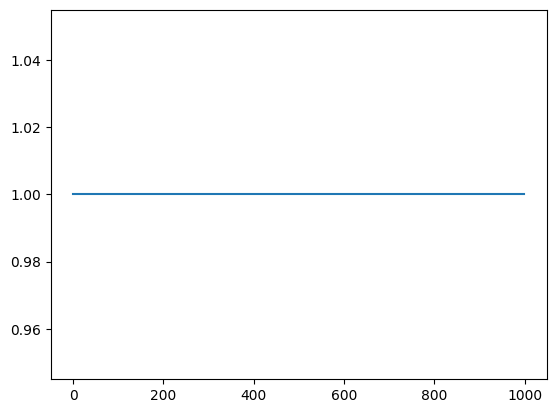

In [23]:
#def train_test_model(train_env, test_env, epochs=5, hidden_dims=[64, 64], training_rounds=20):
trials = Trials()

best = fmin(fn=train_test_model,space=search_space,algo=tpe.suggest, max_evals=30, trials=trials)
best

In [24]:
best

{'batch_size': np.int64(1),
 'conservative_alpha': np.float64(0.566336422139115),
 'discount_factor': np.float64(0.9562430912571531),
 'epochs': np.int64(8),
 'hidden_dims': np.int64(1),
 'is_conservative': np.int64(0),
 'learning_rate': np.float64(1.0383616180001911),
 'soft_update_tau': np.float64(0.5171679927255015),
 'target_update_freq': np.int64(2),
 'training_rounds': np.int64(7)}

## "best" shows data types instead of the parameter values themselves.  Let's get the actual values of the best parameters

In [33]:
def get_trials(trials):
    trial_df = pd.DataFrame(trials.trials)
    misc = trial_df['misc'].apply(lambda row: pd.Series(row))
    result = trial_df['result'].apply(lambda row: pd.Series(row))
    #print(misc)
    vals = misc['vals'].apply(lambda row: pd.Series(row))
    df = pd.concat([result, vals], axis=1)
    return df

expanded_df = get_trials(trials)

print("Best parameter values are: ")
expanded_df.loc[0]



Best parameter values are: 


loss                              -0.15868
status                                  ok
batch_size                             [1]
conservative_alpha     [0.566336422139115]
discount_factor       [0.9562430912571531]
epochs                                 [8]
hidden_dims                            [1]
is_conservative                        [0]
learning_rate         [1.0383616180001911]
soft_update_tau       [0.5171679927255015]
target_update_freq                     [2]
training_rounds                        [7]
Name: 0, dtype: object

In [27]:
# trial_df = pd.DataFrame(trials.trials)
# trial_df

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
0,2,0,None,"{'loss': -0.15868000909923552, 'status': 'ok'}","{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-16 13:26:16.769,2024-10-16 13:38:47.846


In [28]:
# trial_df['misc'][0]

{'tid': 0,
 'cmd': ('domain_attachment', 'FMinIter_Domain'),
 'workdir': None,
 'idxs': {'batch_size': [np.int64(0)],
  'conservative_alpha': [np.int64(0)],
  'discount_factor': [np.int64(0)],
  'epochs': [np.int64(0)],
  'hidden_dims': [np.int64(0)],
  'is_conservative': [np.int64(0)],
  'learning_rate': [np.int64(0)],
  'soft_update_tau': [np.int64(0)],
  'target_update_freq': [np.int64(0)],
  'training_rounds': [np.int64(0)]},
 'vals': {'batch_size': [np.int64(1)],
  'conservative_alpha': [np.float64(0.566336422139115)],
  'discount_factor': [np.float64(0.9562430912571531)],
  'epochs': [np.int64(8)],
  'hidden_dims': [np.int64(1)],
  'is_conservative': [np.int64(0)],
  'learning_rate': [np.float64(1.0383616180001911)],
  'soft_update_tau': [np.float64(0.5171679927255015)],
  'target_update_freq': [np.int64(2)],
  'training_rounds': [np.int64(7)]}}

## Retrain with the best parameters

In [47]:
from hyperopt import space_eval
space_eval(search_space, best)

{'batch_size': 128,
 'conservative_alpha': 0.566336422139115,
 'discount_factor': 0.9562430912571531,
 'epochs': np.int64(8),
 'hidden_dims': (128, 128),
 'is_conservative': True,
 'learning_rate': 1.0383616180001911,
 'soft_update_tau': 0.5171679927255015,
 'target_update_freq': 10,
 'test_env': <OrderEnforcing<TradingEnv<TradingEnv>>>,
 'train_env': <OrderEnforcing<TradingEnv<TradingEnv>>>,
 'training_rounds': np.int64(7)}

In [49]:
# train_env = make_env(train_env_name, train_df, positions, reward_function, trading_fees, daily_rate)
# test_env = make_env(test_env_name, test_df, positions, reward_function, trading_fees, daily_rate)
# best2 = best.copy()

# agent, loss_best = train_model(**best)

TypeError: train_model() missing 1 required positional argument: 'train_env'

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:17<02:05, 17.86s/it]

Market Return : 29.20%   |   Portfolio Return : -1.14%   |   position_change : 78   |   


 25%|██▌       | 2/8 [00:32<01:36, 16.15s/it]

Market Return : 29.20%   |   Portfolio Return : -19.02%   |   position_change : 54   |   


 38%|███▊      | 3/8 [00:50<01:24, 16.95s/it]

Market Return : 29.20%   |   Portfolio Return : -28.54%   |   position_change : 44   |   


 50%|█████     | 4/8 [01:11<01:14, 18.51s/it]

Market Return : 29.20%   |   Portfolio Return : -30.49%   |   position_change : 27   |   


 62%|██████▎   | 5/8 [01:29<00:54, 18.32s/it]

Market Return : 29.20%   |   Portfolio Return : -31.57%   |   position_change : 34   |   


 75%|███████▌  | 6/8 [01:47<00:36, 18.35s/it]

Market Return : 29.20%   |   Portfolio Return : -25.86%   |   position_change : 43   |   


 88%|████████▊ | 7/8 [02:06<00:18, 18.30s/it]

Market Return : 29.20%   |   Portfolio Return : -32.69%   |   position_change : 31   |   


100%|██████████| 8/8 [02:24<00:00, 18.11s/it]

Market Return : 29.20%   |   Portfolio Return : -23.24%   |   position_change : 39   |   


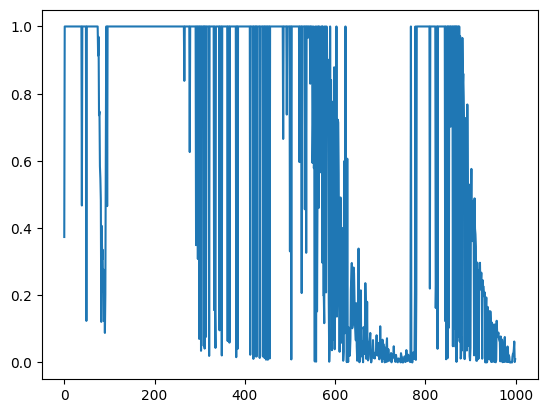

In [51]:
# 
train_env = make_env(train_env_name, train_df, positions, reward_function, trading_fees, daily_rate)
test_env = make_env(test_env_name, test_df, positions, reward_function, trading_fees, daily_rate)

hidden_dims = [[64,64],[128,128], [256, 256]]

best2 = best.copy()

best2['train_env'] = train_env
best2['test_env'] = test_env
best2['batch_size'] = 1
best2['hidden_dims'] = hidden_dims[best2['hidden_dims']]
agent = train_model(**best2)

dict

## Final Results of Best Model

In [57]:
observation, action_space = test_env.reset()

portfolio_return = test_model(test_env, agent)
print(portfolio_return)

Market Return : -15.87%   |   Portfolio Return : 15.87%   |   position_change : 1   |   
{'loss': np.float64(-0.15868116778040298), 'status': 'ok'}


In [59]:
# #env = GymEnvironment(env)

# train_env = GymEnvironment(train_env)
# test_env = GymEnvironment(test_env)

In [60]:


# num_actions = train_env.action_space.n
# agent = PearlAgent(
#     policy_learner=DeepQLearning(
#         state_dim=train_env.observation_space.shape[0],
#         action_space=train_env.action_space, 
#         hidden_dims=[64, 64],
#         training_rounds=20,
#         action_representation_module=OneHotActionTensorRepresentationModule(
#             max_number_actions=num_actions
#         ),
#     ),
#     replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
# )


In [ ]:
## Probably unnecessary
# observation, action_space = train_env.reset()
# observation.shape,action_space

In [62]:
# losses=[]

In [ ]:
# n_epochs=1
# for i in tqdm(range(n_epochs)):
#     observation, action_space = train_env.reset()
#     agent.reset(observation, action_space)
#     done = False
#     while not done:
#         action = agent.act(exploit=False)
#         action_result = train_env.step(action)
#         agent.observe(action_result)
#         loss=agent.learn()
#         [losses.append(l) for l in loss['loss']]
#         done = action_result.done


In [ ]:
# len(losses)

In [56]:
#plt.plot(losses[:1000])

In [ ]:
# observation, action_space = env.reset()
# agent.reset(observation, action_space)
# done = False
# while not done:
#     action = agent.act(exploit=True)
#     action_result = env.step(action)
#     agent.observe(action_result)
#     # loss=agent.learn()
#     # [losses.append(l) for l in loss['loss']]
#     done = action_result.done

# later version
# observation, action_space = test_env.reset()
# agent.reset(observation, action_space)
# done = False
# while not done:
#     action = agent.act(exploit=True)
#     action_result = test_env.step(action)
#     agent.observe(action_result)
#     # loss=agent.learn()
#     done = action_result.done

In [58]:
# Get back the original test environment (get it out of its Pearl wrapper)
og_env=test_env.env.unwrapped

In [59]:
og_env.save_for_render()

In [60]:
renderer = Renderer(render_logs_dir="render_logs")

# Add Custom Lines (Simple Moving Average)
renderer.add_line( name= "sma10", function= lambda df : df["close"].rolling(10).mean(), line_options ={"width" : 1, "color": "purple"})
renderer.add_line( name= "sma20", function= lambda df : df["close"].rolling(20).mean(), line_options ={"width" : 1, "color": "blue"})

renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Oct/2024 23:43:30] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Oct/2024 23:43:43] "GET /update_data/ICPUSD_2024-09-16_03-06-07.pkl HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Oct/2024 23:43:43] "GET /metrics HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Oct/2024 23:43:43] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
#action = agent.act(exploit=False)
#action

In [ ]:
# action_result